<a href="https://colab.research.google.com/github/beckii0930/LLM/blob/main/chembert_BBBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# project_folder = '/content/drive/Mydrive/Colab Notebooks/ChEMBL'
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [ ]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 67.4 MB/s eta 0:00:00


In [ ]:
!pip install kaggle

In [ ]:
import os
!kaggle datasets download -d priyanagda/bbbp-smiles --unzip
# kaggle_json_path = '/content/drive/Mydrive/kaggle/kaggle.json'
# os.makedirs('/root/.kaggle', exist_ok=True)
# !cp {kaggle_json_path} /root/.kaggle/kaggle.kaggle.json

Dataset URL: https://www.kaggle.com/datasets/priyanagda/bbbp-smiles
License(s): unknown
  0% 0.00/45.8k [00:00<?, ?B/s]
100% 45.8k/45.8k [00:00<00:00, 84.6MB/s]


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
pretrained_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
# tokenizer
def smiles_to_embedding(smiles):
  inputs = tokenizer(smiles, return_tensors='pt', max_length=512,
                     truncation = True)
  with torch.no_grad():
    outputs = pretrained_model(**inputs)

  embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
  return embedding

df = pd.read_csv("BBBP.csv")
df

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
...,...,...,...,...
2045,2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2046,2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...
2047,2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...
2048,2052,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...


In [ ]:
from tqdm.notebook import tqdm
class BBBP_Dataset(Dataset):
  def __init__(self, csv_file):
    self.bbbp_df = pd.read_csv(csv_file)
    self.smiles_list = self.bbbp_df['smiles'].to_list()
    self.labels = self.bbbp_df['p_np'].values

    self.embeddings = [smiles_to_embedding(x) for x in tqdm(self.smiles_list,
                                                            desc='SMILES TO EMBEDDING')]

  def __len__(self):
    return len(self.embeddings)

  def __getitem__(self, idx):
    embedding = self.embeddings[idx]
    label = self.labels[idx]

    label_tensor = torch.tensor(label, dtype=torch.float32)
    return embedding, label_tensor

In [ ]:
bbbp_dataset = BBBP_Dataset("BBBP.csv")

from torch.utils.data import random_split
train_size = int(0.8 * len(bbbp_dataset))
test_size = len(bbbp_dataset) - train_size

train_dataset, test_dataset = random_split(bbbp_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)

SMILES TO EMBEDDING:   0%|          | 0/2050 [00:00<?, ?it/s]

In [ ]:
tokenizer

RobertaTokenizerFast(name_or_path='seyonec/ChemBERTa-zinc-base-v1', vocab_size=767, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)

In [ ]:
import torch.nn as nn
import torch.optim as optim
model = nn.Sequential(
    nn.Linear(768, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
  model.train()
  loss_list = []
  for embeddings, labels in train_loader:
    outputs = model(embeddings).squeeze()
    loss=nn.BCELoss()(outputs, labels)
    loss_list.append(loss.item())

    for p in model.parameters():
      p.grad=None
    loss.backward()
    for p in model.parameters():
      p.data -= 0.01 * p.grad
  tmp = sum(loss_list) / len(loss_list)
  print(f"Epoch [{epoch+1}/{num_epochs}], loss:{tmp:.4f}")

Epoch [1/50], loss:0.6231
Epoch [2/50], loss:0.5138
Epoch [3/50], loss:0.4787
Epoch [4/50], loss:0.4392
Epoch [5/50], loss:0.4109
Epoch [6/50], loss:0.3864
Epoch [7/50], loss:0.3665
Epoch [8/50], loss:0.3574
Epoch [9/50], loss:0.3465
Epoch [10/50], loss:0.3379
Epoch [11/50], loss:0.3300
Epoch [12/50], loss:0.3223
Epoch [13/50], loss:0.3182
Epoch [14/50], loss:0.3087
Epoch [15/50], loss:0.3070
Epoch [16/50], loss:0.3040
Epoch [17/50], loss:0.2987
Epoch [18/50], loss:0.2967
Epoch [19/50], loss:0.2926
Epoch [20/50], loss:0.2922
Epoch [21/50], loss:0.2917
Epoch [22/50], loss:0.2920
Epoch [23/50], loss:0.2792
Epoch [24/50], loss:0.2831
Epoch [25/50], loss:0.2776
Epoch [26/50], loss:0.2792
Epoch [27/50], loss:0.2714
Epoch [28/50], loss:0.2686
Epoch [29/50], loss:0.2638
Epoch [30/50], loss:0.2621
Epoch [31/50], loss:0.2581
Epoch [32/50], loss:0.2562
Epoch [33/50], loss:0.2550
Epoch [34/50], loss:0.2534
Epoch [35/50], loss:0.2484
Epoch [36/50], loss:0.2437
Epoch [37/50], loss:0.2486
Epoch [38/

In [ ]:
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
lossi = []
running_loss = 0

for epoch in range(num_epochs):

  model.train()
  train_loss = 0.0
  for embeddings, labels in tqdm(train_loader, desc = "Batching", leave = True):
    embeddings, labels = embeddings.to(device), labels.to(device)

    # forward
    outputs = model(embeddings).squeeze()
    loss=criterion(outputs, labels)

    #backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
    train_loss +=loss.item() * embeddings.size(0)
    lossi.append(loss.item())

  train_loss /= len(train_loader.dataset)
  print(f"Epoch [{epoch+1}/{num_epochs}], loss:{train_loss:.4f}")

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for embeddings, labels in test_loader:
      embeddings, labels = embeddings.to(device), labels.to(device)
      outputs = model(embeddings).squeeze()
      predicted = (outputs > 0.5).float()
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
  accuracy = 100*correct / total
  print(f'Test Accuracy: {accuracy:.2f}%')

Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [1/100], loss:0.0022
Test Accuracy: 88.05%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [2/100], loss:0.0029
Test Accuracy: 87.32%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [3/100], loss:0.0015
Test Accuracy: 87.56%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [4/100], loss:0.0010
Test Accuracy: 87.56%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [5/100], loss:0.0016
Test Accuracy: 88.05%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [6/100], loss:0.0052
Test Accuracy: 87.80%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [7/100], loss:0.0057
Test Accuracy: 88.29%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [8/100], loss:0.0035
Test Accuracy: 88.54%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [9/100], loss:0.0021
Test Accuracy: 87.80%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [10/100], loss:0.0010
Test Accuracy: 87.07%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [11/100], loss:0.0003
Test Accuracy: 87.07%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [12/100], loss:0.0003
Test Accuracy: 86.83%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [13/100], loss:0.0002
Test Accuracy: 86.83%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [14/100], loss:0.0003
Test Accuracy: 87.07%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [15/100], loss:0.0003
Test Accuracy: 87.32%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [16/100], loss:0.0009
Test Accuracy: 87.07%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [17/100], loss:0.0003
Test Accuracy: 87.32%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [18/100], loss:0.0002
Test Accuracy: 87.32%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [19/100], loss:0.0002
Test Accuracy: 87.56%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [20/100], loss:0.0003
Test Accuracy: 87.32%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [21/100], loss:0.0002
Test Accuracy: 87.56%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [22/100], loss:0.0030
Test Accuracy: 88.05%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [23/100], loss:0.0200
Test Accuracy: 86.59%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [24/100], loss:0.0138
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [25/100], loss:0.0056
Test Accuracy: 88.29%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [26/100], loss:0.0016
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [27/100], loss:0.0036
Test Accuracy: 87.80%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [28/100], loss:0.0036
Test Accuracy: 89.27%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [29/100], loss:0.0006
Test Accuracy: 89.51%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [30/100], loss:0.0005
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [31/100], loss:0.0006
Test Accuracy: 88.54%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [32/100], loss:0.0006
Test Accuracy: 88.29%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [33/100], loss:0.0033
Test Accuracy: 88.29%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [34/100], loss:0.0184
Test Accuracy: 85.85%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [35/100], loss:0.0654
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [36/100], loss:0.0084
Test Accuracy: 89.51%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [37/100], loss:0.0056
Test Accuracy: 88.29%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [38/100], loss:0.0025
Test Accuracy: 89.76%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [39/100], loss:0.0012
Test Accuracy: 89.27%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [40/100], loss:0.0007
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [41/100], loss:0.0003
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [42/100], loss:0.0002
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [43/100], loss:0.0001
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [44/100], loss:0.0001
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [45/100], loss:0.0001
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [46/100], loss:0.0001
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [47/100], loss:0.0001
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [48/100], loss:0.0001
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [49/100], loss:0.0001
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [50/100], loss:0.0001
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [51/100], loss:0.0001
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [52/100], loss:0.0001
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [53/100], loss:0.0001
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [54/100], loss:0.0001
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [55/100], loss:0.0001
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [56/100], loss:0.0000
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [57/100], loss:0.0000
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [58/100], loss:0.0000
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [59/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [60/100], loss:0.0000
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [61/100], loss:0.0000
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [62/100], loss:0.0000
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [63/100], loss:0.0000
Test Accuracy: 89.02%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [64/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [65/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [66/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [67/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [68/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [69/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [70/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [71/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [72/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [73/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [74/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [75/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [76/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [77/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [78/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [79/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [80/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [81/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [82/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [83/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [84/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [85/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [86/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [87/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [88/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [89/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [90/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [91/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [92/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [93/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [94/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [95/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [96/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [97/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [98/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [99/100], loss:0.0000
Test Accuracy: 88.78%


Batching:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [100/100], loss:0.0000
Test Accuracy: 88.78%


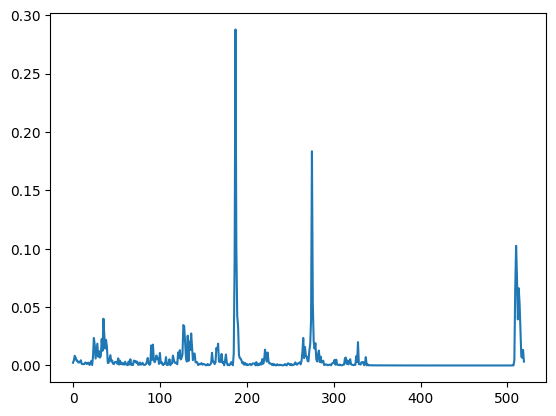

In [ ]:
import matplotlib.pyplot as plt
plt.plot(torch.tensor(lossi).view(-1, 20).mean(1))